2022-10-04 13:21:09.838433: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-04 13:21:09.841795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 13:21:09.841811: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Total number of samples in the original training data =  95
Total number of samples in the generated data =  85
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Train...


2022-10-04 13:21:10.968093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-04 13:21:10.968111: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-04 13:21:10.968123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shivanisri-Latitude-3420): /proc/driver/nvidia/version does not exist
2022-10-04 13:21:10.968295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_605074/464679389.py:135: UserWarning: `Model.fit_generator` is 

Epoch 1/100
85/85 - 2s - loss: 0.0250 - val_loss: 0.0639 - 2s/epoch - 21ms/step
Epoch 2/100
85/85 - 0s - loss: 0.0072 - val_loss: 0.0276 - 336ms/epoch - 4ms/step
Epoch 3/100
85/85 - 0s - loss: 0.0072 - val_loss: 0.0265 - 358ms/epoch - 4ms/step
Epoch 4/100
85/85 - 0s - loss: 0.0067 - val_loss: 0.0264 - 346ms/epoch - 4ms/step
Epoch 5/100
85/85 - 0s - loss: 0.0064 - val_loss: 0.0255 - 319ms/epoch - 4ms/step
Epoch 6/100
85/85 - 0s - loss: 0.0063 - val_loss: 0.0271 - 321ms/epoch - 4ms/step
Epoch 7/100
85/85 - 0s - loss: 0.0060 - val_loss: 0.0274 - 319ms/epoch - 4ms/step
Epoch 8/100
85/85 - 0s - loss: 0.0059 - val_loss: 0.0259 - 320ms/epoch - 4ms/step
Epoch 9/100
85/85 - 0s - loss: 0.0060 - val_loss: 0.0226 - 319ms/epoch - 4ms/step
Epoch 10/100
85/85 - 0s - loss: 0.0058 - val_loss: 0.0218 - 348ms/epoch - 4ms/step
Epoch 11/100
85/85 - 0s - loss: 0.0054 - val_loss: 0.0226 - 333ms/epoch - 4ms/step
Epoch 12/100
85/85 - 0s - loss: 0.0056 - val_loss: 0.0514 - 330ms/epoch - 4ms/step
Epoch 13/100
85

Epoch 100/100
85/85 - 0s - loss: 7.7544e-04 - val_loss: 0.0047 - 329ms/epoch - 4ms/step
Train Score: 11.78 RMSE
Test Score: 35.61 RMSE


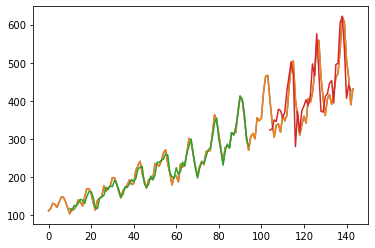

In [1]:
# https://youtu.be/97bZKO6cJfg
"""
Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# load the dataset
dataframe = read_csv('/home/shivanisri/Desktop/LSTM/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


#Use TimeseriesGenerator to organize training data into the right format
#We can use a generator instead......
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
seq_size = length =  10 
batch_size = 1
train_generator = TimeseriesGenerator(train,train,length=length,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55
#With length 40 it generated 55 samples, each of length 40 (by using data of length 95)

# print a couple of samples... 
x, y = train_generator[0]

#Also generate validation data
validation_generator = TimeseriesGenerator(test, test, length=length ,batch_size=batch_size)



#Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

#############################################
#Check SimpleRNN before moving on to LSTM
# print('Build SimpleRNN model...')
# # create and fit pure, simple RNN
# model = Sequential()
# model.add(SimpleRNN(64, input_shape=(length, num_features), activation='relu')) #12
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
# print(model.summary()) 

##################################################
##########################################################
#LSTM single layer with 50 units
# model = Sequential()

# model.add(LSTM(50, input_shape=(length, num_features)))
# model.add(Dense(1))
# model.compile(optimizer = 'adam', loss='mse')
# ###############################################
# ######################################################
#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length, num_features)))
model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')
###############################################

#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions
#from keras.layers import Bidirectional
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
#print('Train...')

#########################################################
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

# trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
# testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

# model = Sequential()
# model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
# model.add(Flatten())
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
#print('Train...')



#########################################
model.fit_generator(generator=train_generator, verbose=2, epochs=100, validation_data=validation_generator)

#############################################
trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[length:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[length:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[length:len(trainPredict)+length, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train)+(length)-1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()





